# Моделювання систем. Лабораторна робота №2

## Краснощок Іван, ІПС-31

In [1]:
import numpy as np
from PIL import Image

Вхідний сигнал - x1.bmp, вихідний сигнал - y6.bmp (згідно з варіантом №6) 

In [2]:
def scale_image(image, scale_factor=1.6):
    return image.resize((int(image.width * scale_factor), int(image.height * scale_factor)))

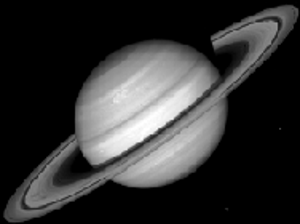

In [3]:
x1_bmp = Image.open('x1.bmp')
scale_image(x1_bmp)

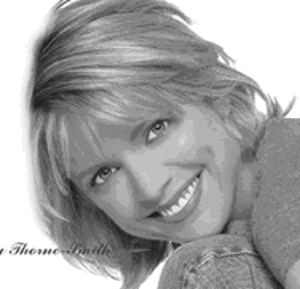

In [4]:
y6_bmp = Image.open('y6.bmp')
scale_image(y6_bmp)

![](Model.jpg)

In [5]:
X = np.vstack((np.array(x1_bmp), np.ones(x1_bmp.width)))
Y = np.array(y6_bmp)

![](Greville.jpg)

In [6]:
def Z(A, A_pinv):
    return np.eye(A_pinv.shape[0]) - A_pinv @ A


def R(A_pinv):
    return A_pinv @ A_pinv.T


def pseudoinverse_Greville(A, eps=1e-9):
    a = A[0].reshape(-1, 1)
    A_pinv = a if np.abs((a.T @ a).item()) <= eps else a / (a.T @ a).item()
    A_pinv = A_pinv.reshape(-1, 1)
    
    m, _ = A.shape
    for i in range(1, m):
        Z_A = Z(A[:i], A_pinv)
        a = A[i].reshape(-1, 1)
        
        formula_denominator = (a.T @ Z_A @ a).item()
        
        if np.abs(formula_denominator) > eps:
            F_A = Z_A
        else:
            F_A = R(A_pinv)
            formula_denominator = 1. + a.T @ F_A @ a
            
        A_pinv = np.hstack((
            (A_pinv - F_A @ a @ a.T @ A_pinv / formula_denominator), 
            (F_A @ a / formula_denominator).reshape(-1, 1)
        ))
        
    return A_pinv

![](MoorePenrose.jpg)

In [7]:
def pseudoinverse_Moore_Penrose(A, eps=1e-9, delta=10):
    m, n = A.shape
    moore_penrose_formula = (
        (lambda A, delta: np.linalg.inv(A.T @ A + delta * delta * np.eye(n)) @ A.T) 
        if m > n else 
        (lambda A, delta: A.T @ np.linalg.inv(A @ A.T + delta * delta * np.eye(m)))
    )
    
    A_pinv = moore_penrose_formula(A, delta)
    
    while True:
        delta /= 2
        A_pinv_prev, A_pinv = A_pinv, moore_penrose_formula(A, delta)
        
        if np.linalg.norm(A_pinv - A_pinv_prev) < eps:
            break
            
    return A_pinv

In [16]:
def get_min_max_scaler(target_array):
    target_min, target_max = target_array.min(), target_array.max()
    
    def min_max_scaler(unscaled_array):
        unscaled_array = unscaled_array.astype(np.float32)
        unscaled_min, unscaled_max = unscaled_array.min(), unscaled_array.max()
        
        unscaled_array = unscaled_array - unscaled_min
        unscaled_array = unscaled_array / (unscaled_max - unscaled_min)
        unscaled_array = unscaled_array * (target_max - target_min)
        return unscaled_array + target_min 
        
    return min_max_scaler


def get_mapper(target_array):
    target_sorted = np.sort(target_array.reshape(-1))
    
    def mapper(unmapped_array):
        unmapped_array_sorted = np.sort(unmapped_array.reshape(-1))
        mapping = dict(zip(unmapped_array_sorted, target_sorted))
        
        return np.vectorize(lambda p: mapping[p])(unmapped_array)
        
    return mapper


def cut_pixels(uncut_array):
    uncut_array = uncut_array.copy()
    uncut_array[uncut_array > 255.] = 255.
    uncut_array[uncut_array < 0.] = 0.
    
    return uncut_array


def get_output_image(pseudoinverse_func):
    A = Y @ pseudoinverse_func(X)
    image = A @ X
    return Image.fromarray(cut_pixels(image).astype(np.uint8), mode='L')

Вихідне зображення при використанні алгоритму, що базується на формулі Гревіля

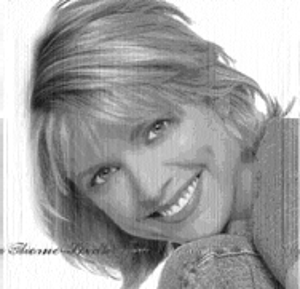

In [18]:
scale_image(get_output_image(pseudoinverse_Greville))

Вихідне зображення при використанні алгоритму, що базується на формулі Мура-Пенроуза

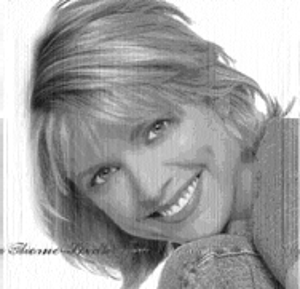

In [17]:
scale_image(get_output_image(pseudoinverse_Moore_Penrose))